## Overview

### Structure

The pipeline is as follows:

Download the city gml files -> Convert to shapefiles -> Divide into grids -> Calculate UMP for each grid -> Save as y

Loop through each grid, download sentinel imagery, store and write as tensor 

### Datasets

- X:
    - Sentinel
- Y:
    - Tokyo (Japan, 2021) https://www.geospatial.jp/ckan/dataset/plateau-tokyo23ku/resource/0bab2b7f-6962-41c8-872f-66ad9b40dcb1?inner_span=True
    - Osaka (Japan, 2021) ^ 
    - New York (USA, 2019) https://github.com/opencitymodel/opencitymodel 

## Import Libraries

In [1]:
# Ensures runtime code is updated when source code of libraries are updated as well
%load_ext autoreload
%autoreload 2

In [7]:
import os.path
import utils.istarmap as istarmap # Patches mp with this to enable tqdm
from multiprocessing import Pool
import pickle
from functools import partial

from itertools import repeat
from glob import glob
import xml.dom.minidom
import tqdm

import pandas as pd
import numpy as np
import math
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import dask_geopandas as dgpd

import fiona
import shapely
import pyproj
from osgeo import gdal


# Modules
from utils.gml_utils import *
from utils import sp_utils


## Convert GML to feather

### Function Definitions

Convert all of the GML files in a folder into a single shapefile

In [3]:
# def multi_to_poly(geometry):
#     if isinstance(geometry, shapely.Polygon):
#         return geometry
#     elif isinstance(geometry, shapely.MultiPolygon):
#         return shapely.ops.unary_union(list(geometry.geoms))

# def xml_extract_gdf(in_path, 
#     lod_tag= "bldg:lod1Solid", 
#     polygon_tag= "gml:Polygon", 
#     coord_tag= "gml:posList", 
#     height_tag= "bldg:measuredHeight", 
#     src_crs= "EPSG:6668", 
#     tgt_crs= "EPSG:3857"):
#     """
#     Extracts the building geometry (first polygon of each building only) and height, and assemble them into a GeoDataFrame\n
#     # Parameters:\n
#     - in_path: File path to the input gml file\n
#     - building_tag: The tag for each building, number of tags should be equivalent to the number of buildings\n
#     - lod_tag: The tag specifying which lod to extract from\n
#     - polygon_tag: The tag for polygons making up each building, only the first polygon will be extracted\n
#     - coord_tag: The tag for the list of coordinates\n
#     - height_tag: The tag for the height, should have same number of instances as buildings\n
#     """
#     # Manually read the gml as xml and extract the geometry
#     doc = xml.dom.minidom.parse(in_path)
#     buildings = doc.getElementsByTagName(lod_tag) # This is Plateau dataset specific
#     buildings_coords = [building\
#                         .getElementsByTagName(polygon_tag)[0]\
#                         .getElementsByTagName(coord_tag)[0]\
#                         .childNodes[0]\
#                         .nodeValue.split(" ") for building in buildings]

#     # Abort if no geometry found
#     if len(buildings_coords) == 0:
#         return None

#     # Conversion is done here to preserve the precision due to python rounding shennanigans
#     transformer = pyproj.Transformer.from_crs(src_crs, tgt_crs)
#     buildings_coords = [
#                         [transformer.transform(buildings_coords[bld][i], 
#                             buildings_coords[bld][i+1]) for i in range(0, len(buildings_coords[bld]), 3)] 
#                         for bld in range(len(buildings_coords))
#                         ]
#     geometry = gpd.GeoSeries([shapely.Polygon(coords) for coords in buildings_coords])
    
#     # Manually extract the height
#     buildings_height = doc.getElementsByTagName(height_tag)

#     # Abort if no height data found
#     if len(buildings_height) == 0:
#         return None

#     buildings_height = [float(height.childNodes[0].nodeValue) for height in buildings_height]
#     height_series = pd.DataFrame(buildings_height, columns= ["height"])

#     gdf = gpd.GeoDataFrame(data= height_series, geometry= geometry)

#     # Remove the NaN values
#     gdf = gdf.dropna().reset_index(drop= True)
#     return gdf

# def gml_to_feather(in_path, out_path, mode= None, log_name= "gml_convert", src_crs= "EPSG:6668", tgt_crs= "EPSG:3857", force_manual= False):
#     """
#     Takes in a gml file and outputs it as a feather file\n
#     W/R with feather files is much faster and takes up much less space than using shp files\n
#     # Parameters:\n
#     - in_path: The path for the gml file\n
#     - out_path: The output path for the shape file, must end with a .shp\n
#     - mode: 
#         - 'o' = overwrites any file at output path, \n
#         - None = raises error if file already exists\n
#     - src_crs: Source projection\n
#     - tgt_crs: Target projection\n
#     """
#     # Extracts features
#     with fiona.open(in_path, 'r') as src:
#         features = list(src)

#     # Converts and places it in geopandas format
#     # There seems to be some gml files without the measured height column, will try to log those files in
#     gdf = gpd.GeoDataFrame.from_features(features)
#     try:
#         # Goes to manual extraction if flag is True
#         # Hacky but it works
#         if force_manual:
#             raise
#         gdf = gdf[['measuredHeight', 'geometry']]
#         gdf.rename(columns={'measuredHeight':'height'}, inplace= True)

#         # Remove the NaN values
#         gdf = gdf.dropna().reset_index(drop= True)

#         # Reproject
#         gdf = gdf.set_crs(src_crs).to_crs(tgt_crs).reset_index(drop= True)
        
#         # Convert coordinates from 3D to 2D
#         gdf_geometry = gpd.GeoSeries.from_wkb(gdf.to_wkb(output_dimension= 2)["geometry"])
#         gdf.drop(["geometry"], axis= 1, inplace= True)
#         gdf = gpd.GeoDataFrame(gdf, geometry= gdf_geometry)

#         # Covert it to correct projection and merge to polygon from multi polygon
#         # This is because multipolygon has stacking polygons which affects the area calculation
#         # gdf = gdf.explode(index_parts= True).set_crs(src_crs).to_crs(tgt_crs).loc[(slice(None), slice(0)), :].reset_index(drop= True)
#         gdf["geometry"] = gdf.apply(lambda x: multi_to_poly(x["geometry"]), axis= 1).reset_index(drop= True)

#     except Exception as e:
#         # If exception occurs try to extract manually
#         gdf_manual = xml_extract_gdf(in_path)

#         if gdf_manual is None:
#             print(f"{e}: {os.path.basename(in_path)}")
#             if not log_name is None:
#                 if not os.path.exists("logs"):
#                     os.makedirs("logs")
#                 with open(f"logs/{log_name}.txt", "a") as f:
#                     f.write(in_path + "\n")
#             return len(gdf)
#         else:
#             gdf = gdf_manual

#     # Check if parent directory exists
#     if not os.path.exists(os.path.dirname(out_path)):
#         os.makedirs(os.path.dirname(out_path))
        
#     # Outputs to the desired path
#     if os.path.exists(out_path):
#         if mode == "a":
#             gdf.to_feather(out_path, mode= "a")
#         elif mode == "o":
#             gdf.to_feather(out_path)
#         else:
#             raise FileExistsError("Output path already exists")
#     else:
#         gdf.to_feather(out_path)
    
#     return 0

# def batch_gml_to_feather(in_dir, out_path, n_processes= 12, log_name= None, mode= None, src_crs= "EPSG:6668", tgt_crs= "EPSG:3857", force_manual= False):

#     # Get all the paths of the gml files
#     in_paths = glob(f"{in_dir}/*.gml")
#     print("Total input files:", len(in_paths))

#     # Reads the gml file and extract features
#     with Pool(processes= n_processes) as pool:
#         r = pool.starmap(
#             gml_to_feather, 
#             zip(in_paths, 
#                 [f'{in_dir}/temp/{os.path.basename(path).replace(".gml", ".feather")}' for path in in_paths], 
#                 repeat(mode), 
#                 repeat(log_name),
#                 repeat(src_crs),
#                 repeat(tgt_crs),
#                 repeat(force_manual)))

#     # Check for invalid buildings
#     print(f"There are {sum(r)} invalid buildings from {len(list(filter(lambda x: x > 0, r)))} files")

#     # Get all the paths of the shp files
#     in_paths = glob(f"{in_dir}/temp/*.feather")
#     print("Total files to merge:", len(in_paths))

#     gdfs = [gpd.read_feather(in_path) for in_path in in_paths]
#     gdf = gpd.GeoDataFrame(pd.concat(gdfs)).reset_index(drop= True)
#     gdf.to_feather(out_path)

#     for temp_file in in_paths:
#         os.remove(temp_file)

#     return gdf

### Tokyo

In [7]:
in_dir = "data/13100_tokyo23-ku_2020_citygml_3_2_op/udx/bldg"
out_path = "data/full_Tokyo_plateau/tokyo_manual.feather"

batch_gml_to_feather(in_dir, out_path, mode= "o", log_name= "tokyo", force_manual= True)

Total input files: 671
There are 0 invalid buildings from 0 files
Total files to merge: 671


,height,geometry
0,6.1,"POLYGON ((15565422.798 4245286.909, 15565416.2..."
1,3.0,"POLYGON ((15565401.386 4245273.087, 15565398.9..."
2,3.5,"POLYGON ((15563817.297 4264833.695, 15563811.6..."
3,11.8,"POLYGON ((15563065.418 4265104.495, 15563064.8..."
4,2.5,"POLYGON ((15563458.540 4264729.005, 15563431.3..."
...,...,...
1768063,8.1,"POLYGON ((15547325.623 4251960.079, 15547330.5..."
1768064,6.3,"POLYGON ((15547878.824 4251983.939, 15547872.9..."
1768065,8.2,"POLYGON ((15548373.420 4252264.298, 15548372.5..."
1768066,12.6,"POLYGON ((15548263.540 4251615.712, 15548262.3..."


### Osaka

In [131]:
in_dir = "data/osaka/udx/bldg"
out_path = "data/osaka/osaka_multipoly.feather"

batch_gml_to_feather(in_dir, out_path, mode= "o", log_name= "osaka")

Total input files: 269
"['measuredHeight'] not in index": 51357370_bldg_6697_op.gml
There are 5 invalid buildings from 1 files
Total files to merge: 268


,height,geometry
0,11.5,"POLYGON ((15072613.536 4114048.044, 15072620.2..."
1,6.2,"POLYGON ((15072558.081 4114007.990, 15072589.9..."
2,6.3,"POLYGON ((15072628.568 4114021.301, 15072645.5..."
3,6.3,"POLYGON ((15072607.323 4114020.869, 15072624.3..."
4,5.6,"POLYGON ((15072607.724 4113953.180, 15072625.6..."
...,...,...
560020,9.4,"POLYGON ((15078755.742 4127329.912, 15078759.7..."
560021,8.5,"POLYGON ((15078476.219 4127165.962, 15078475.3..."
560022,3.9,"POLYGON ((15078306.179 4126767.674, 15078306.3..."
560023,6.6,"POLYGON ((15079362.582 4127440.974, 15079370.9..."


In [137]:
osaka_multi_gdf = gpd.read_feather("data/osaka/osaka_multipoly.feather")
osaka_gdf = gpd.read_feather("data/osaka/osaka_fixed.feather")
osaka_multi_gdf.area.sum() - osaka_gdf.area.sum()

5.960464477539063e-08

### New York

In [4]:
in_dir = "data/NewYork_2/gml_files"
out_path = "data/NewYork_2/new_york_multi.feather"
src_crs = "EPSG:4326"

batch_gml_to_feather(in_dir, out_path, mode= "o", log_name= "new_york", src_crs= src_crs)

Total input files: 170
There are 0 invalid buildings from 0 files
Total files to merge: 170


,height,geometry
0,5.73,"POLYGON ((-8209083.637 5566815.941, -8209079.1..."
1,5.73,"POLYGON ((-8209092.654 5566766.181, -8209071.0..."
2,4.38,"POLYGON ((-8209005.825 5566671.511, -8208994.5..."
3,5.73,"POLYGON ((-8209241.377 5566652.734, -8209229.4..."
4,5.73,"POLYGON ((-8209105.122 5566643.188, -8209078.4..."
...,...,...
5716434,4.38,"POLYGON ((-8215328.048 5027787.294, -8215319.3..."
5716435,4.74,"POLYGON ((-8215264.930 5027796.217, -8215251.8..."
5716436,5.17,"POLYGON ((-8215132.827 5027481.400, -8215125.5..."
5716437,5.45,"POLYGON ((-8215366.164 5027732.854, -8215365.3..."


In [ ]:
ny_multi_gdf = gpd.read_feather("data/NewYork_2/new_york_multi.feather")
ny_gdf = gpd.read_feather("data/NewYork_2/new_york.feather")
ny_multi_gdf.area.sum() - ny_gdf.area.sum()

0.926774263381958

## Examine problem files

Tokyo Dataset is facing empty multipolygons, so this part aims to read it manually without fiona

In [4]:
# Fiona fails to load the multipolygons somehow
with open("logs/tokyo.txt") as f:
    files = f.read()

files = files.split("\n")
problem_gdfs = []

for f in files:
    # Extracts features
    with fiona.open(f, 'r') as src:
        features = list(src)
    
    problem_gdfs.append(gpd.GeoDataFrame.from_features(features))

problem_gdfs = gpd.GeoDataFrame(pd.concat(problem_gdfs)).reset_index(drop= True)
problem_gdfs = problem_gdfs[["geometry", "measuredHeight"]]

problem_gdfs

,geometry,measuredHeight
0,MULTIPOLYGON EMPTY,2.8
1,MULTIPOLYGON EMPTY,3.6
2,MULTIPOLYGON EMPTY,3.6
3,MULTIPOLYGON EMPTY,16.1
4,MULTIPOLYGON EMPTY,9.3
...,...,...
3649,MULTIPOLYGON EMPTY,6.2
3650,MULTIPOLYGON EMPTY,42.2
3651,MULTIPOLYGON EMPTY,10.3
3652,MULTIPOLYGON EMPTY,19.3


In [91]:
# Manually read the gml as xml and extract the geometry
doc = xml.dom.minidom.parse("data/13100_tokyo23-ku_2020_citygml_3_2_op/udx/bldg/53394525_bldg_6697_2_op.gml")
# buildings = doc.getElementsByTagName("bldg:lod1Solid") # This is Plateau dataset specific
buildings = doc.getElementsByTagName("bldg:Building") # This is Plateau dataset specific
buildings_coords = [building\
                    .getElementsByTagName("bldg:lod1Solid")[0]\
                    .getElementsByTagName("gml:Polygon")[0]\
                    .getElementsByTagName("gml:posList")[0]\
                    .childNodes[0]\
                    .nodeValue.split(" ") for building in buildings]
# Conversion is done here to preserve the precision due to python rounding shennanigans
transformer = pyproj.Transformer.from_crs("EPSG:6668", "EPSG:3857")
buildings_coords = [
                    [transformer.transform(buildings_coords[bld][i], 
                        buildings_coords[bld][i+1]) for i in range(0, len(buildings_coords[bld]), 3)] 
                    for bld in range(len(buildings_coords))
                    ]
geometry = gpd.GeoSeries([shapely.Polygon(coords) for coords in buildings_coords])

# Manually extract the height
buildings_height = doc.getElementsByTagName("bldg:measuredHeight")
buildings_height = [float(height.childNodes[0].nodeValue) for height in buildings_height]
height_series = pd.DataFrame(buildings_height, columns= ["height"])

gdf = gpd.GeoDataFrame(data= height_series, geometry= geometry)
gdf

,height,geometry
0,47.2,"POLYGON ((15551281.170 4257975.203, 15551281.1..."
1,9.6,"POLYGON ((15550861.584 4257238.269, 15550857.6..."
2,21.3,"POLYGON ((15550987.243 4257966.064, 15550986.8..."
3,18.9,"POLYGON ((15551071.511 4257915.512, 15551077.0..."
4,29.4,"POLYGON ((15550974.838 4257788.037, 15550971.7..."
...,...,...
1375,7.1,"POLYGON ((15550804.951 4257253.915, 15550804.5..."
1376,6.9,"POLYGON ((15550916.926 4257346.304, 15550903.6..."
1377,7.1,"POLYGON ((15550121.593 4257452.333, 15550122.1..."
1378,2.7,"POLYGON ((15550766.039 4257183.125, 15550763.5..."


Osaka has straight up missing height tags even within the gml file

In [4]:
with open("logs/osaka.txt") as f:
    files = f.read()

files = files.split("\n")
problem_gdfs = []

for f in files:
    # Extracts features
    with fiona.open(f, 'r') as src:
        features = list(src)
    
    problem_gdfs.append(gpd.GeoDataFrame.from_features(features))

problem_gdfs = gpd.GeoDataFrame(pd.concat(problem_gdfs)).reset_index(drop= True)
# problem_gdfs = problem_gdfs[["geometry", "measuredHeight"]]
problem_gdfs

,geometry,gml_id,建物ID,枝番,prefecture,city,key,codeValue,theme,imageURI,mimeType
0,"MULTIPOLYGON Z (((135.37611 34.64792 1.25830, ...",BLD_4e8cebca-8759-4283-9f2c-099eeac4a7ae,27100-bldg-1,1.0,27.0,27100.0,2.0,2.0,NaN,NaN,NaN
1,"MULTIPOLYGON Z (((135.37730 34.64591 2.22380, ...",BLD_96cc393f-efde-464e-8e90-129c4ccad2ef,27100-bldg-3,1.0,27.0,27100.0,2.0,2.0,NaN,NaN,NaN
2,"MULTIPOLYGON Z (((135.37911 34.64358 3.14470, ...",BLD_80a14177-1694-4eab-b843-7c527b887402,27100-bldg-4,1.0,27.0,27100.0,2.0,2.0,NaN,NaN,NaN
3,"MULTIPOLYGON Z (((135.37907 34.64354 3.28320, ...",BLD_9f6e5948-6968-4192-87aa-458ebc269f55,27100-bldg-5,1.0,27.0,27100.0,2.0,2.0,NaN,NaN,NaN
4,"MULTIPOLYGON Z (((135.37687 34.64791 3.55590, ...",BLD_a3b46c03-5a24-4494-bf90-f07d3738e228,27100-bldg-2,1.0,27.0,27100.0,2.0,2.0,NaN,NaN,NaN
5,None,fme-gen-ece9cd30-11f8-492b-9a2d-ad6153a7f88a,NaN,NaN,NaN,NaN,NaN,NaN,rgbTexture,NaN,NaN
6,None,fme-gen-ebed22fd-125f-45b4-815d-9080d68b9498,NaN,NaN,NaN,NaN,NaN,NaN,rgbTexture,NaN,NaN
7,None,fme-gen-d9f03ada-8ffd-418f-afb2-067ab5012918,NaN,NaN,NaN,NaN,NaN,NaN,rgbTexture,NaN,NaN
8,None,fme-gen-6e1841d6-676a-4d90-b39d-a70ee4691c0f,NaN,NaN,NaN,NaN,NaN,NaN,rgbTexture,NaN,NaN
9,None,fme-gen-0dc34428-8b95-46c5-8dd9-a976f8c3f919,NaN,NaN,NaN,NaN,NaN,NaN,rgbTexture,52350422_bldg_6697_appearance/27100-bldg-32887...,image/jpg


Tokyo still has way lesser buildings than the original one, but forcing the manual method solves most of it issue

In [3]:
old_tokyo_gdf = gpd.read_file("data/full_Tokyo_plateau/plateau_3857_2D.shp")
new_tokyo_gdf = gpd.read_feather("data/full_Tokyo_plateau/tokyo_fixed.feather")
len(old_tokyo_gdf), len(new_tokyo_gdf)

(1768294, 1740787)

Osaka doesn't change for forced manual so normal mode works fine

In [13]:
osaka_1_gdf = gpd.read_feather("data/osaka/osaka_full.feather")
osaka_2_gdf = gpd.read_feather("data/osaka/osaka_full_2.feather")
osaka_3_gdf = gpd.read_feather("data/osaka/osaka_full_manual.feather")
len(osaka_1_gdf), len(osaka_2_gdf), len(osaka_3_gdf)

(544280, 560025, 560025)

## Divide into grids

### Load files

In [2]:
# Tokyo
tokyo_gdf = gpd.read_feather("data/full_Tokyo_plateau/tokyo_fixed.feather")

# Osaka
osaka_gdf = gpd.read_feather("data/osaka/osaka_fixed.feather")

# New York
ny_gdf = gpd.read_feather("data/NewYork_2/new_york.feather")

# # Final check for nan values
len(tokyo_gdf[pd.DataFrame.any(tokyo_gdf.isna(), axis= 1)]), len(osaka_gdf[pd.DataFrame.any(osaka_gdf.isna(), axis= 1)]), len(ny_gdf[pd.DataFrame.any(ny_gdf.isna(), axis= 1)])

### Extract Points from datasets

In [8]:
# # Tokyo
# tokyo_pts = []
# for i in range(len(tokyo_gdf)):
#     tokyo_pts.append(np.dstack(tokyo_gdf.geometry[i].exterior.coords.xy).squeeze(0))
# tokyo_pts = np.concatenate(tokyo_pts)

# # Osaka
# osaka_pts = []
# for i in range(len(osaka_gdf)):
#     osaka_pts.append(np.dstack(osaka_gdf.geometry[i].exterior.coords.xy).squeeze(0))
# osaka_pts = np.concatenate(osaka_pts)

# New York
ny_pts = []
for i in range(len(ny_gdf)):
    ny_pts.append(np.dstack(ny_gdf.geometry[i].exterior.coords.xy).squeeze(0))
ny_pts = np.concatenate(ny_pts)

# tokyo_pts.shape, osaka_pts.shape, ny_pts.shape

### Get concave hulls that are bounding the dataset

In [4]:
# '''
# Copyright (C) 2018  Andre Lester Kruger
# ConcaveHull.py is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 2 of the License, or
# (at your option) any later version.
# ConcaveHull.py is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
# You should have received a copy of the GNU General Public License
# along with ConcaveHull.py.  If not, see <http://www.gnu.org/licenses/>.
# '''

# import bisect
# from collections import OrderedDict
# import math
# #import numpy as np
# import matplotlib.tri as tri
# from shapely.geometry import LineString
# from shapely.geometry import Polygon
# from shapely.ops import linemerge


# class ConcaveHull:
    
#     def __init__(self):
#         self.triangles = {}
#         self.crs = {}
        
    
#     def loadpoints(self, points):
#         #self.points = np.array(points)
#         self.points = points
        
        
#     def edge(self, key, triangle):
#         '''Calculate the length of the triangle's outside edge
#         and returns the [length, key]'''
#         pos = triangle[1].index(-1)
#         if pos==0:
#             x1, y1 = self.points[triangle[0][0]]
#             x2, y2 = self.points[triangle[0][1]]
#         elif pos==1:
#             x1, y1 = self.points[triangle[0][1]]
#             x2, y2 = self.points[triangle[0][2]]
#         elif pos==2:
#             x1, y1 = self.points[triangle[0][0]]
#             x2, y2 = self.points[triangle[0][2]]
#         length = ((x1-x2)**2+(y1-y2)**2)**0.5
#         rec = [length, key]
#         return rec
        
    
#     def triangulate(self):
        
#         if len(self.points) < 2:
#             raise Exception('CountError: You need at least 3 points to Triangulate')
        
#         temp = list(zip(*self.points))
#         x, y = list(temp[0]), list(temp[1])
#         del(temp)
        
#         triang = tri.Triangulation(x, y)
        
#         self.triangles = {}
        
#         for i, triangle in enumerate(triang.triangles):
#             self.triangles[i] = [list(triangle), list(triang.neighbors[i])]
        

#     def calculatehull(self, tol=50):
        
#         self.tol = tol
        
#         if len(self.triangles) == 0:
#             self.triangulate()
        
#         # All triangles with one boundary longer than the tolerance (self.tol)
#         # is added to a sorted deletion list.
#         # The list is kept sorted from according to the boundary edge's length
#         # using bisect        
#         deletion = []    
#         self.boundary_vertices = set()
#         for i, triangle in self.triangles.items():
#             if -1 in triangle[1]:
#                 for pos, neigh in enumerate(triangle[1]):
#                     if neigh == -1:
#                         if pos == 0:
#                             self.boundary_vertices.add(triangle[0][0])
#                             self.boundary_vertices.add(triangle[0][1])
#                         elif pos == 1:
#                             self.boundary_vertices.add(triangle[0][1])
#                             self.boundary_vertices.add(triangle[0][2])
#                         elif pos == 2:
#                             self.boundary_vertices.add(triangle[0][0])
#                             self.boundary_vertices.add(triangle[0][2])
#             if -1 in triangle[1] and triangle[1].count(-1) == 1:
#                 rec = self.edge(i, triangle)
#                 if rec[0] > self.tol and triangle[1].count(-1) == 1:
#                     bisect.insort(deletion, rec)
                    
#         while len(deletion) != 0:
#             # The triangles with the longest boundary edges will be 
#             # deleted first
#             item = deletion.pop()
#             ref = item[1]
#             flag = 0
            
#             # Triangle will not be deleted if it already has two boundary edges            
#             if self.triangles[ref][1].count(-1) > 1:
#                 continue
                
#             # Triangle will not be deleted if the inside node which is not
#             # on this triangle's boundary is already on the boundary of 
#             # another triangle
#             adjust = {0: 2, 1: 0, 2: 1}            
#             for i, neigh in enumerate(self.triangles[ref][1]):
#                 j = adjust[i]
#                 if neigh == -1 and self.triangles[ref][0][j] in self.boundary_vertices:
#                     flag = 1
#                     break
#             if flag == 1:
#                 continue
           
#             for i, neigh in enumerate(self.triangles[ref][1]):
#                 if neigh == -1:
#                     continue
#                 pos = self.triangles[neigh][1].index(ref)
#                 self.triangles[neigh][1][pos] = -1
#                 rec = self.edge(neigh, self.triangles[neigh])
#                 if rec[0] > self.tol and self.triangles[rec[1]][1].count(-1) == 1:
#                     bisect.insort(deletion, rec)
                    
#             for pt in self.triangles[ref][0]:
#                 self.boundary_vertices.add(pt)
                                        
#             del self.triangles[ref]
            
#         self.polygon()
            
                    

#     def polygon(self):
        
#         edgelines = []
#         for i, triangle in self.triangles.items():
#             if -1 in triangle[1]:
#                 for pos, value in enumerate(triangle[1]):
#                     if value == -1:
#                         if pos==0:
#                             x1, y1 = self.points[triangle[0][0]]
#                             x2, y2 = self.points[triangle[0][1]]
#                         elif pos==1:
#                             x1, y1 = self.points[triangle[0][1]]
#                             x2, y2 = self.points[triangle[0][2]]
#                         elif pos==2:
#                             x1, y1 = self.points[triangle[0][0]]
#                             x2, y2 = self.points[triangle[0][2]]
#                         line = LineString([(x1, y1), (x2, y2)])
#                         edgelines.append(line)

#         bound = linemerge(edgelines)
    
#         self.boundary = Polygon(bound.coords)

In [9]:
# # Toyko
# tokyo_hull = ConcaveHull()
# tokyo_hull.loadpoints(tokyo_pts)
# tokyo_hull.calculatehull(tol= 1000)
# tokyo_hull.boundary
# with open("data/full_Tokyo_plateau/tokyo_concavehull.pkl", "wb") as f:
#     pickle.dump(tokyo_hull.boundary, f)

# del tokyo_pts
# del tokyo_hull

# # Osaka
# osaka_hull = ConcaveHull()
# osaka_hull.loadpoints(osaka_pts)
# osaka_hull.calculatehull(tol= 1000)
# osaka_hull.boundary
# with open("data/osaka/osaka_concavehull.pkl", "wb") as f:
#     pickle.dump(osaka_hull.boundary, f)

# del osaka_pts
# del osaka_hull

# New York
ny_hull = ConcaveHull()
# Due to size of data, have to skip points
ny_hull.loadpoints(ny_pts[::10])
# To include forested/non-built area, have to increase tolerance
ny_hull.calculatehull(tol= 2000)
ny_hull.boundary
with open("data/NewYork_2/ny_concavehull.pkl", "wb") as f:
    pickle.dump(ny_hull.boundary, f)

# del ny_pts
# del ny_hull

### Divide into grids based on min and max point, then filter out valid grids

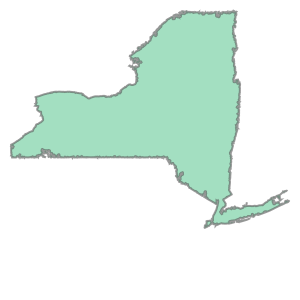

In [3]:
with open("data/full_Tokyo_plateau/tokyo_concavehull.pkl", "rb") as f:
    tokyo_hull = pickle.load(f)

with open("data/osaka/osaka_concavehull.pkl", "rb") as f:
    osaka_hull = pickle.load(f)

with open("data/NewYork_2/ny_concavehull.pkl", "rb") as f:
    ny_hull = pickle.load(f)

tokyo_hull
osaka_hull
ny_hull

# From the bottom left, generate grids
# Grids will be stored in polygons aka GeoDataFrame

In [35]:
# class GridGenerator():
#     """
#     A class to generate a series of grids in GeoDataFrame format that can be used for futher processing
#     """
#     def __init__(self, polygon: shapely.Polygon):
#         """
#         Initialises the class\n
#         # Parameters:\n
#         - polygon: The polygon that the grid\n
#         """
#         self.polygon = polygon
#         self.min_x = min(self.polygon.exterior.coords.xy[0])
#         self.max_x = max(self.polygon.exterior.coords.xy[0])
#         self.min_y = min(self.polygon.exterior.coords.xy[1])
#         self.max_y = max(self.polygon.exterior.coords.xy[1])
#         self.grids = None

#     def generateCell(self, x_coord, y_coord, width):
#         """
#         Generates a Polygon with x_coord and y_coord as the LL corner
#         """
#         x0 = x_coord
#         x1 = x_coord + width
#         y0 = y_coord
#         y1 = y_coord + width

#         return shapely.Polygon([[x0, y0], [x1, y0], [x1, y1], [x0, y1]])

#     def generateGrid(self, step, width, round_f= None, n_processes= 12) -> gpd.GeoDataFrame:
#         """
#         Generates the grid from the polygon used to instantiate the class
#         # Parameters:\n
#         - step: The distance* between each grid\n
#         - width: The dimensions of each grid (square)\n  
#         - crop: If True (Default), constraints the grids to be within the polyon only\n
#         - round: The function to round the initial coordinates, defaults to None\n
#         * distance/dimensions will be in the same reference system as the polygon\n
#         """

#         if not round_f is None:
#             min_x = round_f(self.min_x)
#             max_x = round_f(self.max_x)
#             min_y = round_f(self.min_y)
#             max_y = round_f(self.max_y)    
#         else:
#             min_x = self.min_x
#             max_x = self.max_x
#             min_y = self.min_y
#             max_y = self.max_y  
            
#         grids = [[x, y] for x in range(min_x, max_x, step) for y in range(min_y, max_y, step)]

#         grids = [self.generateCell(*grid, width= width) for grid in grids]

#         grids = gpd.GeoDataFrame(geometry= grids)
        
#         # Use this to speed up processing
#         grids = dgpd.from_geopandas(grids, n_processes)
        
#         # grids = list(filter(lambda x: self.polygon.contains(x), tqdm.tqdm(grids, desc= "Filtering Cells")))
#         filter_df = grids.apply(self.polygon.contains, axis= 1, meta={'geometry': 'bool'}).compute()

#         grids = grids[filter_df["geometry"]].compute().reset_index(drop= True)
        
#         self.grids = gpd.GeoDataFrame(geometry= grids["geometry"])
#         return self.grids

In [37]:
tokyo_grid_gen = GridGenerator(tokyo_hull)
tokyo_grid_gen.generateGrid(step= 500, width= 1000, round_f= round).to_feather("data/full_Tokyo_plateau/tokyo_grid.feather")

osaka_grid_gen = GridGenerator(osaka_hull)
osaka_grid_gen.generateGrid(step= 500, width= 1000, round_f= round).to_feather("data/osaka/osaka_grid.feather")

ny_grid_gen = GridGenerator(ny_hull)
ny_grid_gen.generateGrid(step= 500, width= 1000, round_f= round).to_feather("data/NewYork_2/ny_grid.feather")

/home/chan/anaconda3/envs/remote-sensing-landuse/lib/python3.8/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


## Calculate UMP and export as y

In [3]:
# Tokyo
tokyo_gdf = gpd.read_feather("data/full_Tokyo_plateau/tokyo_fixed.feather")
tokyo_grid = gpd.read_feather("data/full_Tokyo_plateau/tokyo_grid.feather")

# Osaka
osaka_gdf = gpd.read_feather("data/osaka/osaka_multipoly.feather")
osaka_grid = gpd.read_feather("data/osaka/osaka_grid.feather")

# New York
ny_gdf = gpd.read_feather("data/NewYork_2/new_york_multi.feather")
ny_grid = gpd.read_feather("data/NewYork_2/ny_grid.feather")

In [4]:
len(ny_grid), len(ny_gdf)

(916019, 5716439)

Area: 1000000.0


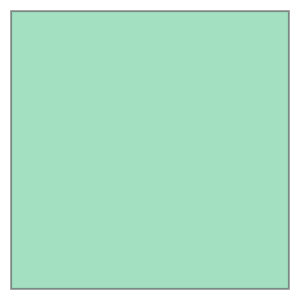

In [5]:
# Sample of a cell
print("Area:", osaka_grid["geometry"][0].area)
osaka_grid["geometry"][0]

### Demo

In [23]:
np.clip(10, 0, 1)   


1

In [25]:
osaka_gdf[:10]
calculateUMP(osaka_gdf, osaka_grid["geometry"][0])

{'AverageHeightArea': 23.321947080728076,
 'AverageHeightBuilding': 9.481818181818182,
 'AverageHeightTotalArea': 0.2878379437277183,
 'Displacement': 0.0009568369634676615,
 'FrontalAreaIndex': 0.005289593160466849,
 'MaximumHeight': 38.4,
 'Percentile': 98,
 'PercentileHeight': 33.90000000000001,
 'PlanarAreaIndex': 0.012341934519076716,
 'RoughnessLength': 0.00022359466733766674,
 'StandardDeviation': 3.0691962418986156}

In [25]:
# Demo code
pd.concat([osaka_grid[:10], osaka_grid[:10].apply(lambda x: calculateUMP(osaka_gdf, x["geometry"]), axis= 1, result_type= "expand")], axis= 1).dtypes

geometry                  geometry
PlanarAreaIndex            float64
MaximumHeight              float64
AverageHeightBuilding      float64
AverageHeightArea          float64
AverageHeightTotalArea     float64
PercentileHeight           float64
FrontalAreaIndex           float64
Percentile                 float64
StandardDeviation          float64
dtype: object

### Actual Calculation

#### Single-threaded Method

In [13]:
# Single-threaded method
from tqdm.auto import tqdm
tqdm.pandas()

# Osaka
pd.concat([osaka_grid, osaka_grid.progress_apply(lambda x: calculateUMP(osaka_gdf, x["geometry"]), axis= 1, result_type= "expand")], axis= 1).to_feather("data/Y_UMP/Y_osaka_3.feather")

# 2:07

  0%|          | 0/1145 [00:00<?, ?it/s]

In [4]:
# Tokyo
from tqdm.auto import tqdm
tqdm.pandas()

pd.concat([tokyo_grid, tokyo_grid.progress_apply(lambda x: calculateUMP(tokyo_gdf, x["geometry"]), axis= 1, result_type= "expand")], axis= 1).to_feather("data/Y_UMP/Y_tokyo_3.feather")

# 9:55

  0%|          | 0/3286 [00:00<?, ?it/s]

/home/chan/remote-sensing-landuse/utils/gml_utils.py:521: RuntimeWarning: invalid value encountered in double_scalars
  z_mac = (1 - d / r["AverageHeightTotalArea"]) * math.exp(-(0.5 * beta * c_lb/(k**2) * ((1-d/r["AverageHeightTotalArea"])) * r["FrontalAreaIndex"])**(-0.5)) * r["AverageHeightTotalArea"]
/home/chan/remote-sensing-landuse/utils/gml_utils.py:521: RuntimeWarning: invalid value encountered in double_scalars
  z_mac = (1 - d / r["AverageHeightTotalArea"]) * math.exp(-(0.5 * beta * c_lb/(k**2) * ((1-d/r["AverageHeightTotalArea"])) * r["FrontalAreaIndex"])**(-0.5)) * r["AverageHeightTotalArea"]


In [ ]:
# NY
from tqdm.auto import tqdm
tqdm.pandas()

pd.concat([ny_grid, ny_grid.progress_apply(lambda x: calculateUMP(ny_gdf, x["geometry"]), axis= 1, result_type= "expand")], axis= 1).to_feather("data/Y_UMP/Y_ny.feather")

# 1:49

In [5]:
calculateUMP(ny_gdf, ny_grid["geometry"][99])

{'AverageHeightArea': 3.97,
 'AverageHeightBuilding': 3.97,
 'AverageHeightTotalArea': 0.0003777804138821149,
 'Displacement': 0.0005317394985035243,
 'FrontalAreaIndex': 5.082291353099048e-05,
 'MaximumHeight': 3.97,
 'Percentile': 98,
 'PercentileHeight': 3.97,
 'PlanarAreaIndex': 9.515879442874432e-05,
 'RoughnessLength': 9.145032780761446e-36,
 'StandardDeviation': 0.03872341437180672}

#### Parallel using Dask

Crashes easily

In [8]:
# Parallel using dask
# Somehow kernel dies when using this
from tqdm.dask import TqdmCallback

osaka_grid_d = dgpd.from_geopandas(osaka_grid, 4)

r = osaka_grid_d.apply(
    lambda x: calculateUMP(osaka_gdf, x["geometry"]), 
    # lambda x: {"col1":1, "col2":2},
    # meta={"col1": 'int64', "col2": 'int64'},
    axis= 1, 
    result_type= "expand", 
    meta= {
        'AverageHeightArea':"float32", 
        'AverageHeightBuilding':"float32", 
        'AverageHeightTotalArea':"float32", 
        'Displacement':"float32", 
        'FrontalAreaIndex':"float32", 
        'MaximumHeight':"float32", 
        'Percentile':"float32", 
        'PercentileHeight':"float32", 
        'PlanarAreaIndex':"float32", 
        'RoughnessLength':"float32", 
        'StandardDeviation':"float32"
        }
    )

with TqdmCallback(desc= "compute"):
    result = r.compute()

# pd.concat([osaka_grid, result], axis= 1)
pd.concat([osaka_grid, result], axis= 1).to_feather("data/Y_UMP/Y_osaka_4.feather")

# 1:36
# 2:35
# 4:35
# 8:35

# 12 - 1:37 (new)
# 4 - 1:25
# 2 - 1:29
# 6 - 1:29

# Full
# 4 - 

compute:   0%|          | 0/4 [00:00<?, ?it/s]

In [9]:
from tqdm.dask import TqdmCallback

tokyo_grid_d = dgpd.from_geopandas(tokyo_grid, 4)

r = tokyo_grid_d.apply(
    lambda x: calculateUMP(tokyo_gdf, x["geometry"]), 
    # lambda x: {"col1":1, "col2":2},
    # meta={"col1": 'int64', "col2": 'int64'},
    axis= 1, 
    result_type= "expand", 
    meta= {
        'AverageHeightArea':"float16", 
        'AverageHeightBuilding':"float16", 
        'AverageHeightTotalArea':"float16", 
        'Displacement':"float16", 
        'FrontalAreaIndex':"float16", 
        'MaximumHeight':"float16", 
        'Percentile':"float16", 
        'PercentileHeight':"float16", 
        'PlanarAreaIndex':"float16", 
        'RoughnessLength':"float16", 
        'StandardDeviation':"float16"
        }
    )

with TqdmCallback(desc= "compute"):
    result = r.compute()

pd.concat([tokyo_grid, result], axis= 1).to_feather("data/Y_tokyo.feather")

# 1:36
# 2:35
# 4:35
# 8:35

# 4 - 2:05


compute:   0%|          | 0/4 [00:00<?, ?it/s]

/home/chan/remote-sensing-landuse/utils/gml_utils.py:513: RuntimeWarning: invalid value encountered in double_scalars
  z_mac = (1 - d / r["AverageHeightTotalArea"]) * math.exp(-(0.5 * beta * c_lb/(k**2) * ((1-d/r["AverageHeightTotalArea"])) * r["FrontalAreaIndex"])**(-0.5)) * r["AverageHeightTotalArea"]
/home/chan/remote-sensing-landuse/utils/gml_utils.py:513: RuntimeWarning: invalid value encountered in double_scalars
  z_mac = (1 - d / r["AverageHeightTotalArea"]) * math.exp(-(0.5 * beta * c_lb/(k**2) * ((1-d/r["AverageHeightTotalArea"])) * r["FrontalAreaIndex"])**(-0.5)) * r["AverageHeightTotalArea"]


In [4]:
from tqdm.dask import TqdmCallback

ny_grid_d = dgpd.from_geopandas(ny_grid, 4)

r = ny_grid_d.apply(
    lambda x: calculateUMP(gpd.clip(ny_gdf, x["geometry"]), x["geometry"]), 
    # lambda x: calculateUMP(ny_gdf, x["geometry"]), 
    # lambda x: {"col1":1, "col2":2},
    # meta={"col1": 'int64', "col2": 'int64'},
    axis= 1, 
    result_type= "expand", 
    meta= {
        'AverageHeightArea':"float32", 
        'AverageHeightBuilding':"float32", 
        'AverageHeightTotalArea':"float32", 
        'Displacement':"float32", 
        'FrontalAreaIndex':"float32", 
        'MaximumHeight':"float32", 
        'Percentile':"float32", 
        'PercentileHeight':"float32", 
        'PlanarAreaIndex':"float32", 
        'RoughnessLength':"float32", 
        'StandardDeviation':"float32"
        }
    )

with TqdmCallback(desc= "compute"):
    result = r.compute()


pd.concat([ny_grid, result], axis= 1).to_feather("data/Y_ny.feather")

# 1:36
# 2:35
# 4:35
# 8:35

# 12 - 1:37 (new)
# 4 - 1:25
# 2 - 1:29
# 6 - 1:29

compute:   0%|          | 0/4 [00:00<?, ?it/s]

#### Manual Parallel method

In [4]:
# Get the envelope of the entire area from the hull
with open("data/full_Tokyo_plateau/tokyo_concavehull.pkl", "rb") as f:
    tokyo_hull = pickle.load(f)

with open("data/osaka/osaka_concavehull.pkl", "rb") as f:
    osaka_hull = pickle.load(f)

with open("data/NewYork_2/ny_concavehull.pkl", "rb") as f:
    ny_hull = pickle.load(f)

osaka_hull.envelope

In [33]:
def calculateUMP_batch(shp_df, clip_poly_list, percentile= 98):
    """
    Calculates UMP in batches of cells, wraps around the calculateUMP function\n
    Function is defined here instead of utils as multiprocessing only can pickle top-level defined functions\n
    # Parameters:\n
    - shp_df: The `GeoDataFrame` that contains the building data
    - clip_poly_list: A `List` of `Polygon`s that each acts as a cell for which the UMP will be calculated
    - percentile: The percentile to get for the one of the UMPs 'PercentileHeight'
    """
    r = []

    for cell in clip_poly_list:
        d = {"geometry":cell}
        d.update(calculateUMP(shp_df, cell, percentile))
        r.append(d)
    
    r_gdf = gpd.GeoDataFrame.from_dict(r)
    return r_gdf

# Divide into n portions, with n overlap

def split_polygon(bounding_polygon: shapely.Polygon, n_splits: int, buffer: float):
    """
    Takes a `Polygon` and returns an evenly split `List` of `Polygon`s based on its envelope
    """  
    min_x, min_y, max_x, max_y = bounding_polygon.envelope.bounds
    width = max_x - min_x
    height = max_y - min_y
    width_step = width / n_splits
    height_step = height / n_splits

    # len should be == n_splits
    segments = [shapely.Polygon([
        (x - buffer, y - buffer), # LL
        (x + width_step + buffer, y - buffer), # LR
        (x + width_step + buffer, y + height_step + buffer), # UR
        (x - buffer, y + height_step + buffer), # UL
        ]) 
        for x in np.linspace(min_x, max_x, num= n_splits, endpoint= False) 
        for y in np.linspace(min_y, max_y, num= n_splits, endpoint= False)]
    
    return segments

def parallel_UMP_calc(building_gdf: gpd.GeoDataFrame, grid_gdf: gpd.GeoDataFrame, segments, n_processes):
    """
    Takes in a GeoDataFrame of building footprints and height, and a `List` of `Polygons`, for each of which to calculate the UMP for buildings within
    """
    # Divide the grids
    segmented_grid = []
    for segment in segments:
        # Only includes cells that are fully within the segment
        segmented_grid.append(grid_gdf["geometry"][grid_gdf["geometry"].within(segment)])

    # Divide the gdf
    segmented_gdf = []
    for segment in segments:
        # Buildings are just clipped
        segmented_gdf.append(building_gdf.clip(segment))

    # Runs in parallel, but no point in more processes than segments
    result = []
    with Pool(min(n_processes, len(segments))) as pool:
        for r in tqdm.tqdm(pool.istarmap(calculateUMP_batch, zip(segmented_gdf, segmented_grid)), total= len(segmented_gdf)):
            result.append(r)
    
    return result
    

#### Osaka

In [34]:
segments = split_polygon(osaka_hull, 4, 1000)
r = parallel_UMP_calc(osaka_gdf, osaka_grid, segments, 8)
r = pd.concat(r, axis= 0).drop_duplicates(subset= ["geometry"], ignore_index= True)
# r.to_feather("data/Y_UMP/Y_osaka_4.feather")
len(r)

100%|██████████| 16/16 [01:23<00:00,  5.24s/it]


1145

#### Tokyo

In [36]:
# Note that due to the larger size we are splitting it into smaller segments just in case
segments = split_polygon(tokyo_hull, 6, 1000)
print("Finished splitting")
r = parallel_UMP_calc(tokyo_gdf, tokyo_grid, segments, 8)
print("Finished calculating")
r = pd.concat(r, axis= 0).drop_duplicates(subset= ["geometry"], ignore_index= True)
# r.to_feather("data/Y_UMP/Y_toyko_4.feather")
len(r)

Finished splitting


100%|██████████| 36/36 [03:34<00:00,  5.95s/it]


Finished calculating


3286

#### New York

In [37]:
len(ny_grid)

916019

In [ ]:
# This is done in screen session to run continuously instead of notebook
# Note that due to the larger size we are splitting it into smaller segments just in case
segments = split_polygon(ny_hull, 95, 1000)
print("Finished splitting")
r = parallel_UMP_calc(ny_gdf, ny_grid, segments, 8)
print("Finished calculating")
r = pd.concat(r, axis= 0).drop_duplicates(subset= ["geometry"], ignore_index= True)
r.to_feather("data/Y_UMP/Y_ny.feather")
len(r)

Finished splitting


100%|██████████| 36/36 [03:34<00:00,  5.95s/it]


Finished calculating


3286

## Download Sentinel and export as X

Main purpose here is to map each y to an instance of x.

This means that data can be loaded on the go during the training process, rather than all at once. However, this also means that it will take up much more space due to the overlapping nature. Unless another function is defined that can merge from separate files but storage is not an issue for now.

In [13]:
import ee
# Only need to authenticate for use of gee methods
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

import dl_sentinel as ds
from utils import gee_downloader as gd


### Load Y

In [6]:
# Osaka
Y_osaka = gpd.read_feather("data/Y_UMP/Y_osaka.feather")

# Tokyo
Y_tokyo = gpd.read_feather("data/Y_UMP/Y_tokyo.feather")

len(Y_osaka), len(Y_tokyo)

(1145, 3286)

### Download all regions into the respective folder

### Osaka

#### Download the entire TIFF at once for efficiency

There are also issues with downloading small files indivdually

In [21]:
with open("data/osaka/osaka_concavehull.pkl", "rb") as f:
    hull = pickle.load(f)
# hull.bounds
lower_left = sp_utils.convertCoords(*hull.bounds[:2], src= "EPSG:3857", target= "EPSG:4326")
upper_right = sp_utils.convertCoords(*hull.bounds[2:], src= "EPSG:3857", target= "EPSG:4326")
bounds = [*lower_left[::-1], *upper_right[::-1]]
bounds

[135.3803515471555, 34.58691457472519, 135.59914986052672, 34.76830050793767]

In [24]:
# Get the image (works for all regions?)
s2HR = ds.get_s2SR(ee.Geometry.Point(135.484802, 34.672314)) # Coordinates needed if not gee will return a blank image

s2HR_osaka = ds.remove_clouds(ds.filterCollection(s2HR, [2020], "Y_S")).median()

In [ ]:
downloader = gd.BaseDownloader("data/X_sentinel")
downloader.download_image(s2HR_osaka, initial_bounds= bounds, base_filename= "sentinel_fullOsaka")

#### Crop and save into corresponding cells

In [37]:
filename = "data/osaka/Sentinel_fullOsaka.tif"
data = gdal.Open(filename, gdal.GA_ReadOnly)

In [45]:
X_dir = "data/X_sentinel/osaka"
for cell in tqdm.tqdm(Y_osaka["geometry"]): 
    warp = gdal.Warp(f"{X_dir}/Sentinel_{'_'.join(map(str, map(int, cell.bounds)))}.tiff", data, srcSRS= "EPSG:4326", dstSRS='EPSG:3857', outputBounds= cell.bounds)
    warp = None

100%|██████████| 1145/1145 [00:02<00:00, 513.63it/s]


### Tokyo

#### Download the entire TIFF at once for efficiency

There are also issues with downloading small files indivdually

In [50]:
with open("data/full_Tokyo_plateau/tokyo_concavehull.pkl", "rb") as f:
    hull = pickle.load(f)
# hull.bounds
lower_left = sp_utils.convertCoords(*hull.bounds[:2], src= "EPSG:3857", target= "EPSG:4326")
upper_right = sp_utils.convertCoords(*hull.bounds[2:], src= "EPSG:3857", target= "EPSG:4326")
bounds = [*lower_left[::-1], *upper_right[::-1]]
bounds

[139.56303368676444, 35.532655211473696, 139.91754313441487, 35.81742435191188]

In [51]:
# Get the image (works for all regions?)
s2HR = ds.get_s2SR(ee.Geometry.Point(*bounds[:2])) # Coordinates needed if not gee will return a blank image

s2HR_tokyo = ds.remove_clouds(ds.filterCollection(s2HR, [2021], "Y_S")).median()

In [ ]:
downloader = gd.BaseDownloader("data/X_sentinel")
downloader.download_image(s2HR_osaka, initial_bounds= bounds, base_filename= "sentinel_fullTokyo")

#### Crop and save into corresponding cells

In [53]:
filename = "data/full_Tokyo_plateau/Sentinel_fullTokyo.tiff"
data = gdal.Open(filename, gdal.GA_ReadOnly)

In [55]:
X_dir = "data/X_sentinel/tokyo"
for cell in tqdm.tqdm(Y_tokyo["geometry"]): 
    warp = gdal.Warp(f"{X_dir}/Sentinel_{'_'.join(map(str, map(int, cell.bounds)))}.tiff", data, srcSRS= "EPSG:4326", dstSRS='EPSG:3857', outputBounds= cell.bounds)
    warp = None

100%|██████████| 3286/3286 [00:06<00:00, 523.40it/s]


## Data Checking

This section is to ensure that there are no Null values and other anomalies with the data

In [6]:
# Osaka
Y_osaka = gpd.read_feather("data/Y_UMP/Y_osaka_3.feather")

# Tokyo
Y_tokyo = gpd.read_feather("data/Y_UMP/Y_tokyo_3.feather")

print(f"Osaka: {len(glob('data/X_sentinel/osaka/*.tiff'))}/{len(Y_osaka)}")
print(f"Tokyo: {len(glob('data/X_sentinel/tokyo/*.tiff'))}/{len(Y_tokyo)}")


Osaka: 1145/1145
Tokyo: 3286/3286


In [8]:
Y_osaka[pd.DataFrame.any(Y_osaka.isna(), axis= 1)]

,geometry,AverageHeightArea,AverageHeightBuilding,AverageHeightTotalArea,Displacement,FrontalAreaIndex,MaximumHeight,Percentile,PercentileHeight,PlanarAreaIndex,RoughnessLength,StandardDeviation


In [7]:
Y_tokyo[pd.DataFrame.any(Y_tokyo.isna(), axis= 1)]

,geometry,AverageHeightArea,AverageHeightBuilding,AverageHeightTotalArea,Displacement,FrontalAreaIndex,MaximumHeight,Percentile,PercentileHeight,PlanarAreaIndex,RoughnessLength,StandardDeviation
